<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
Supplementary code for the <a href="http://mng.bz/orYv">Build a Large Language Model From Scratch</a> book by <a href="https://sebastianraschka.com">Sebastian Raschka</a><br>
<br>Code repository: <a href="https://github.com/rasbt/LLMs-from-scratch">https://github.com/rasbt/LLMs-from-scratch</a>
</font>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="http://mng.bz/orYv"><img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/cover-small.webp" width="100px"></a>
</td>
</tr>
</table>


# Chapter 2: Working with Text Data

Packages that are being used in this notebook:

In [1]:
from importlib.metadata import version

print("torch version:", version("torch"))
print("tiktoken version:", version("tiktoken"))

torch version: 2.9.1
tiktoken version: 0.12.0


- This chapter covers data preparation and sampling to get input data "ready" for the LLM

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/01.webp?timestamp=1" width="700px">

## 2.1 Understanding word embeddings

- No code in this section

- There are many forms of embeddings; we focus on text embeddings in this book

 <img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/02.webp" width="700px">

- LLMs work with embeddings in high-dimensional spaces (i.e., thousands of dimensions)
- Since we can't visualize such high-dimensional spaces (we humans think in 1, 2, or 3 dimensions), the figure below illustrates a 2-dimensional embedding space

 <img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/03.webp" width="700px">

## 2.2 Tokenizing text

- In this section, we tokenize text, which means breaking text into smaller units, such as individual words and punctuation characters

 <img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/04.webp" width="700px">

- Load raw text we want to work with
- [The Verdict by Edith Wharton](https://en.wikisource.org/wiki/The_Verdict) is a public domain short story

In [2]:
import os
import requests

if not os.path.exists("the-verdict.txt"):
    url = (
        "https://raw.githubusercontent.com/rasbt/"
        "LLMs-from-scratch/main/ch02/01_main-chapter-code/"
        "the-verdict.txt"
    )
    file_path = "the-verdict.txt"

    response = requests.get(url, timeout=30)
    response.raise_for_status()
    with open(file_path, "wb") as f:
        f.write(response.content)


# The book originally used the following code below
# However, urllib uses older protocol settings that
# can cause problems for some readers using a VPN.
# The `requests` version above is more robust
# in that regard.

"""
import os
import urllib.request

if not os.path.exists("the-verdict.txt"):
    url = ("https://raw.githubusercontent.com/rasbt/"
           "LLMs-from-scratch/main/ch02/01_main-chapter-code/"
           "the-verdict.txt")
    file_path = "the-verdict.txt"
    urllib.request.urlretrieve(url, file_path)
"""

'\nimport os\nimport urllib.request\n\nif not os.path.exists("the-verdict.txt"):\n    url = ("https://raw.githubusercontent.com/rasbt/"\n           "LLMs-from-scratch/main/ch02/01_main-chapter-code/"\n           "the-verdict.txt")\n    file_path = "the-verdict.txt"\n    urllib.request.urlretrieve(url, file_path)\n'

<br>

---

<br>

#### Troubleshooting SSL certificate errors

- Some readers reported seeing ssl.SSLCertVerificationError: `SSL: CERTIFICATE_VERIFY_FAILED` when running `urllib.request.urlretrieve` in VSCode or Jupyter. 
- This usually means Python's certificate bundle is outdated.


**Fixes**

- Use Python ≥ 3.9; you can check your Python version by executing the following code:
```python
import sys
print(sys.__version__)
```
- Upgrade the cert bundle:
  - pip: `pip install --upgrade certifi`
  - uv: `uv pip install --upgrade certifi`
- Restart the Jupyter kernel after upgrading.
- If you still encounter an `ssl.SSLCertVerificationError` when executing the previous code cell, please see the discussion at [more information here on GitHub](https://github.com/rasbt/LLMs-from-scratch/pull/403)

<br>

---

<br>

In [3]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()
    
print("Total number of character:", len(raw_text))
print(raw_text[:99])

Total number of character: 20479
I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


- The goal is to tokenize and embed this text for an LLM
- Let's develop a simple tokenizer based on some simple sample text that we can then later apply to the text above
- The following regular expression will split on whitespaces

In [4]:
import re

text = "Hello, world. This, is a test."
result = re.split(r'(\s)', text)

print(result)

['Hello,', ' ', 'world.', ' ', 'This,', ' ', 'is', ' ', 'a', ' ', 'test.']


- We don't only want to split on whitespaces but also commas and periods, so let's modify the regular expression to do that as well

In [5]:
result = re.split(r'([,.]|\s)', text)

print(result)

['Hello', ',', '', ' ', 'world', '.', '', ' ', 'This', ',', '', ' ', 'is', ' ', 'a', ' ', 'test', '.', '']


- As we can see, this creates empty strings, let's remove them

In [6]:
# Strip whitespace from each item and then filter out any empty strings.
result = [item for item in result if item.strip()]
print(result)

['Hello', ',', 'world', '.', 'This', ',', 'is', 'a', 'test', '.']


- This looks pretty good, but let's also handle other types of punctuation, such as periods, question marks, and so on

In [7]:
text = "Hello, world. Is this-- a test?"

result = re.split(r'([,.:;?_!"()\']|--|\s)', text)
result = [item.strip() for item in result if item.strip()]
print(result)

['Hello', ',', 'world', '.', 'Is', 'this', '--', 'a', 'test', '?']


- This is pretty good, and we are now ready to apply this tokenization to the raw text

 <img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/05.webp" width="700px">

In [8]:
preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', raw_text)
preprocessed = [item.strip() for item in preprocessed if item.strip()]
print(preprocessed[:30])

['I', 'HAD', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to', 'hear', 'that', ',', 'in']


- Let's calculate the total number of tokens

In [9]:
print(len(preprocessed))

4690


## 2.3 Converting tokens into token IDs

- Next, we convert the text tokens into token IDs that we can process via embedding layers later

 <img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/06.webp" width="700px">

- From these tokens, we can now build a vocabulary that consists of all the unique tokens

In [10]:
all_words = sorted(set(preprocessed))
vocab_size = len(all_words)

print(vocab_size)

1130


In [11]:
vocab = {token:integer for integer,token in enumerate(all_words)}

- Below are the first 50 entries in this vocabulary:

In [12]:
for i, item in enumerate(vocab.items()):
    print(item)
    if i >= 50:
        break

('!', 0)
('"', 1)
("'", 2)
('(', 3)
(')', 4)
(',', 5)
('--', 6)
('.', 7)
(':', 8)
(';', 9)
('?', 10)
('A', 11)
('Ah', 12)
('Among', 13)
('And', 14)
('Are', 15)
('Arrt', 16)
('As', 17)
('At', 18)
('Be', 19)
('Begin', 20)
('Burlington', 21)
('But', 22)
('By', 23)
('Carlo', 24)
('Chicago', 25)
('Claude', 26)
('Come', 27)
('Croft', 28)
('Destroyed', 29)
('Devonshire', 30)
('Don', 31)
('Dubarry', 32)
('Emperors', 33)
('Florence', 34)
('For', 35)
('Gallery', 36)
('Gideon', 37)
('Gisburn', 38)
('Gisburns', 39)
('Grafton', 40)
('Greek', 41)
('Grindle', 42)
('Grindles', 43)
('HAD', 44)
('Had', 45)
('Hang', 46)
('Has', 47)
('He', 48)
('Her', 49)
('Hermia', 50)


- Below, we illustrate the tokenization of a short sample text using a small vocabulary:

 <img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/07.webp?123" width="700px">

- Putting it now all together into a tokenizer class

In [13]:
class SimpleTokenizerV1:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = {i:s for s,i in vocab.items()}
    
    def encode(self, text):
        # Getting individual tokens
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        print(f"Preprocessed tokens (first 10): {preprocessed[:10]}")
        
        # Get rid of empty tokens and strip whitespace
        preprocessed = [
            item.strip() for item in preprocessed if item.strip()
        ]
        print(f"Filtered tokens (first 10): {preprocessed[:10]}")

        # Convert to integer IDs
        ids = [self.str_to_int[s] for s in preprocessed]
        print(f"Encoded IDs (first 10): {ids[:10]}")
        return ids
        
    def decode(self, ids):
        # Convert integer IDs back to strings
        text = " ".join([self.int_to_str[i] for i in ids])
        # Replace spaces before the specified punctuations
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
        return text

- The `encode` function turns text into token IDs
- The `decode` function turns token IDs back into text

 <img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/08.webp?123" width="700px">

- We can use the tokenizer to encode (that is, tokenize) texts into integers
- These integers can then be embedded (later) as input of/for the LLM

In [14]:
tokenizer = SimpleTokenizerV1(vocab)

text = """"It's the last he painted, you know," 
           Mrs. Gisburn said with pardonable pride."""
ids = tokenizer.encode(text)
#print(ids)

Preprocessed tokens (first 10): ['', '"', 'It', "'", 's', ' ', 'the', ' ', 'last', ' ']
Filtered tokens (first 10): ['"', 'It', "'", 's', 'the', 'last', 'he', 'painted', ',', 'you']
Encoded IDs (first 10): [1, 56, 2, 850, 988, 602, 533, 746, 5, 1126]


- We can decode the integers back into text

In [15]:
tokenizer.decode(ids)

'" It\' s the last he painted, you know," Mrs. Gisburn said with pardonable pride.'

In [16]:
tokenizer.decode(tokenizer.encode(text))

Preprocessed tokens (first 10): ['', '"', 'It', "'", 's', ' ', 'the', ' ', 'last', ' ']
Filtered tokens (first 10): ['"', 'It', "'", 's', 'the', 'last', 'he', 'painted', ',', 'you']
Encoded IDs (first 10): [1, 56, 2, 850, 988, 602, 533, 746, 5, 1126]


'" It\' s the last he painted, you know," Mrs. Gisburn said with pardonable pride.'

## 2.4 Adding special context tokens

- It's useful to add some "special" tokens for unknown words and to denote the end of a text

 <img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/09.webp?123" width="700px">

- Some tokenizers use special tokens to help the LLM with additional context
- Some of these special tokens are
  - `[BOS]` (beginning of sequence) marks the beginning of text
  - `[EOS]` (end of sequence) marks where the text ends (this is usually used to concatenate multiple unrelated texts, e.g., two different Wikipedia articles or two different books, and so on)
  - `[PAD]` (padding) if we train LLMs with a batch size greater than 1 (we may include multiple texts with different lengths; with the padding token we pad the shorter texts to the longest length so that all texts have an equal length)
- `[UNK]` to represent words that are not included in the vocabulary

- Note that GPT-2 does not need any of these tokens mentioned above but only uses an `<|endoftext|>` token to reduce complexity
- The `<|endoftext|>` is analogous to the `[EOS]` token mentioned above
- GPT also uses the `<|endoftext|>` for padding (since we typically use a mask when training on batched inputs, we would not attend padded tokens anyways, so it does not matter what these tokens are)
- GPT-2 does not use an `<UNK>` token for out-of-vocabulary words; instead, GPT-2 uses a byte-pair encoding (BPE) tokenizer, which breaks down words into subword units which we will discuss in a later section



- We use the `<|endoftext|>` tokens between two independent sources of text:

 <img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/10.webp" width="700px">

- Let's see what happens if we tokenize the following text:

In [17]:
# tokenizer = SimpleTokenizerV1(vocab)

# text = "Hello, do you like tea. Is this-- a test?"

# tokenizer.encode(text)

- The above produces an error because the word "Hello" is not contained in the vocabulary
- To deal with such cases, we can add special tokens like `"<|unk|>"` to the vocabulary to represent unknown words
- Since we are already extending the vocabulary, let's add another token called `"<|endoftext|>"` which is used in GPT-2 training to denote the end of a text (and it's also used between concatenated text, like if our training datasets consists of multiple articles, books, etc.)

In [18]:
all_tokens = sorted(list(set(preprocessed)))
all_tokens.extend(["<|endoftext|>", "<|unk|>"])

vocab = {token:integer for integer,token in enumerate(all_tokens)}

In [19]:
len(vocab.items())

1132

In [20]:
for i, item in enumerate(list(vocab.items())[-10:]):
    print(item)

('year', 1122)
('years', 1123)
('yellow', 1124)
('yet', 1125)
('you', 1126)
('younger', 1127)
('your', 1128)
('yourself', 1129)
('<|endoftext|>', 1130)
('<|unk|>', 1131)


- We also need to adjust the tokenizer accordingly so that it knows when and how to use the new `<unk>` token

In [21]:
class SimpleTokenizerV2:
    def __init__(self, vocab):
        # Initialize mappings for string to integer and vice versa
        self.str_to_int = vocab
        self.int_to_str = { i:s for s,i in vocab.items()}
    
    def encode(self, text):
        # Getting individual tokens
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)

        # Get rid of empty tokens and strip whitespace
        preprocessed = [item.strip() for item in preprocessed if item.strip()]

        # Map unknown tokens to "<|unk|>"
        preprocessed = [
            item if item in self.str_to_int 
            else "<|unk|>" for item in preprocessed
        ]
        # Convert to integer IDs
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids
        
    def decode(self, ids):
        # Convert integer IDs back to strings
        text = " ".join([self.int_to_str[i] for i in ids])
        
        # Replace spaces before the specified punctuations
        text = re.sub(r'\s+([,.:;?!"()\'])', r'\1', text)
        return text

Let's try to tokenize text with the modified tokenizer:

In [22]:
tokenizer = SimpleTokenizerV2(vocab)

text1 = "Hello, do you like tea?"
text2 = "In the sunlit terraces of the palace."

text = " <|endoftext|> ".join((text1, text2))

print(text)

Hello, do you like tea? <|endoftext|> In the sunlit terraces of the palace.


In [23]:
tokenizer.encode(text)

[1131, 5, 355, 1126, 628, 975, 10, 1130, 55, 988, 956, 984, 722, 988, 1131, 7]

In [24]:
tokenizer.decode(tokenizer.encode(text))

'<|unk|>, do you like tea? <|endoftext|> In the sunlit terraces of the <|unk|>.'

## 2.5 BytePair encoding

- GPT-2 used BytePair encoding (BPE) as its tokenizer
- it allows the model to break down words that aren't in its predefined vocabulary into smaller subword units or even individual characters, enabling it to handle out-of-vocabulary words
- For instance, if GPT-2's vocabulary doesn't have the word "unfamiliarword," it might tokenize it as ["unfam", "iliar", "word"] or some other subword breakdown, depending on its trained BPE merges
- The original BPE tokenizer can be found here: [https://github.com/openai/gpt-2/blob/master/src/encoder.py](https://github.com/openai/gpt-2/blob/master/src/encoder.py)
- In this chapter, we are using the BPE tokenizer from OpenAI's open-source [tiktoken](https://github.com/openai/tiktoken) library, which implements its core algorithms in Rust to improve computational performance
- I created a notebook in the [./bytepair_encoder](../02_bonus_bytepair-encoder) that compares these two implementations side-by-side (tiktoken was about 5x faster on the sample text)

In [25]:
!pip install tiktoken --break-system-packages

Defaulting to user installation because normal site-packages is not writeable


In [26]:
import importlib
import tiktoken

print("tiktoken version:", importlib.metadata.version("tiktoken"))

tiktoken version: 0.12.0


In [27]:
tokenizer_gpt2 = tiktoken.encoding_for_model(model_name="gpt-2")
tokenizer_gpt35 = tiktoken.encoding_for_model(model_name="gpt-3.5")
tokenizer_gpt4 = tiktoken.encoding_for_model(model_name="gpt-4")
tokenizer_gpt5 = tiktoken.encoding_for_model(model_name="gpt-5")

In [28]:
text = (
    "Hello, do you like tea? <|endoftext|> In the sunlit terraces\n"
     "of someunknownPlace."
)

for tokenizer in [tokenizer_gpt2, tokenizer_gpt35, tokenizer_gpt4, tokenizer_gpt5]:
    integers = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
    print(f"integers from model {tokenizer}: {integers}")
    strings = tokenizer.decode(integers)
    print(f"strings from model {tokenizer}: {strings}\n")

integers from model <Encoding 'gpt2'>: [15496, 11, 466, 345, 588, 8887, 30, 220, 50256, 554, 262, 4252, 18250, 8812, 2114, 198, 1659, 617, 34680, 27271, 13]
strings from model <Encoding 'gpt2'>: Hello, do you like tea? <|endoftext|> In the sunlit terraces
of someunknownPlace.

integers from model <Encoding 'cl100k_base'>: [9906, 11, 656, 499, 1093, 15600, 30, 220, 100257, 763, 279, 7160, 32735, 7317, 2492, 198, 1073, 1063, 16476, 17826, 13]
strings from model <Encoding 'cl100k_base'>: Hello, do you like tea? <|endoftext|> In the sunlit terraces
of someunknownPlace.

integers from model <Encoding 'cl100k_base'>: [9906, 11, 656, 499, 1093, 15600, 30, 220, 100257, 763, 279, 7160, 32735, 7317, 2492, 198, 1073, 1063, 16476, 17826, 13]
strings from model <Encoding 'cl100k_base'>: Hello, do you like tea? <|endoftext|> In the sunlit terraces
of someunknownPlace.

integers from model <Encoding 'o200k_base'>: [13225, 11, 621, 481, 1299, 17966, 30, 220, 199999, 730, 290, 7334, 32758, 173297, 198,

- BPE tokenizers break down unknown words into subwords and individual characters:

 <img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/11.webp" width="700px">

## 2.6 Data sampling with a sliding window

- We train LLMs to generate one word at a time, so we want to prepare the training data accordingly where the next word in a sequence represents the target to predict:

 <img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/12.webp" width="700px">

In [29]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()
    
enc_text = tokenizer_gpt2.encode(raw_text)
print(len(enc_text))

5145


- For each text chunk, we want the inputs and targets
- Since we want the model to predict the next word, the targets are the inputs shifted by one position to the right

In [30]:
enc_sample = enc_text[50:]

In [31]:
context_size = 4 

x = enc_sample[:context_size]
y = enc_sample[1:context_size+1]

print(f"x: {x}")
print(f"y:      {y}")

x: [290, 4920, 2241, 287]
y:      [4920, 2241, 287, 257]


- One by one, the prediction would look like as follows:

In [32]:
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]

    print(context, "---->", desired)

[290] ----> 4920
[290, 4920] ----> 2241
[290, 4920, 2241] ----> 287
[290, 4920, 2241, 287] ----> 257


In [33]:
for i in range(1, context_size+1):
    context = enc_sample[:i]
    desired = enc_sample[i]

    print(tokenizer_gpt2.decode(context), "---->", tokenizer_gpt2.decode([desired]))

 and ---->  established
 and established ---->  himself
 and established himself ---->  in
 and established himself in ---->  a


- We will take care of the next-word prediction in a later chapter after we covered the attention mechanism
- For now, we implement a simple data loader that iterates over the input dataset and returns the inputs and targets shifted by one

- Install and import PyTorch (see Appendix A for installation tips)

In [34]:
import torch
print("PyTorch version:", torch.__version__)

/home/the-think-pod/.local/lib/python3.12/site-packages/torch/_subclasses/functional_tensor.py:279: UserWarning: Failed to initialize NumPy: No module named 'numpy' (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:84.)
  cpu = _conversion_method_template(device=torch.device("cpu"))


PyTorch version: 2.9.1+cu128


- We use a sliding window approach, changing the position by +1:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/13.webp?123" width="800px">

- Create dataset and dataloader that extract chunks from the input text dataset

In [35]:
from torch.utils.data import Dataset, DataLoader


class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})
        assert len(token_ids) > max_length, "Number of tokenized inputs must at least be equal to max_length+1"

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

In [50]:
def create_dataloader_v1(txt, batch_size=4, max_length=256, 
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=5):

    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer_gpt2, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

- Let's test the dataloader with a batch size of 1 for an LLM with a context size of 4:

In [37]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

In [38]:
dataloader = create_dataloader_v1(
    raw_text, batch_size=1, max_length=5, stride=1, shuffle=False
)

data_iter = iter(dataloader)
first_batch = next(data_iter)
print(first_batch)

[tensor([[    40, 148954,   3324,   4525,  10874]]), tensor([[148954,   3324,   4525,  10874, 165003]])]


In [39]:
second_batch = next(data_iter)
print(second_batch)

[tensor([[148954,   3324,   4525,  10874, 165003]]), tensor([[  3324,   4525,  10874, 165003,  33750]])]


- An example using stride equal to the context length (here: 4) as shown below:

 <img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/14.webp" width="700px">

- We can also create batched outputs
- Note that we increase the stride here so that we don't have overlaps between the batches, since more overlap could lead to increased overfitting

In [51]:
dataloader = create_dataloader_v1(raw_text, batch_size=8, max_length=4, stride=4, shuffle=False)

data_iter = iter(dataloader)
inputs, targets = next(data_iter)
print("Inputs:\n", inputs)
print("\nTargets:\n", targets)

Inputs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Targets:
 tensor([[  367,  2885,  1464,  1807],
        [ 3619,   402,   271, 10899],
        [ 2138,   257,  7026, 15632],
        [  438,  2016,   257,   922],
        [ 5891,  1576,   438,   568],
        [  340,   373,   645,  1049],
        [ 5975,   284,   502,   284],
        [ 3285,   326,    11,   287]])


## 2.7 Creating token embeddings

- The data is already almost ready for an LLM
- But lastly let us embed the tokens in a continuous vector representation using an embedding layer
- Usually, these embedding layers are part of the LLM itself and are updated (trained) during model training

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/15.webp" width="700px">

- Suppose we have the following four input examples with input ids 2, 3, 5, and 1 (after tokenization):

In [52]:
input_ids = torch.tensor([2, 3, 5, 1])
print("Input IDs:", input_ids)
print("Input IDs shape:", input_ids.shape)

Input IDs: tensor([2, 3, 5, 1])
Input IDs shape: torch.Size([4])


- For the sake of simplicity, suppose we have a small vocabulary of only 6 words and we want to create embeddings of size 3:

In [42]:
vocab_size = 6
output_dim = 3

torch.manual_seed(123)
embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

- This would result in a 6x3 weight matrix:

In [53]:
print(embedding_layer.weight)

Parameter containing:
tensor([[ 0.3374, -0.1778, -0.1690],
        [ 0.9178,  1.5810,  1.3010],
        [ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-1.1589,  0.3255, -0.6315],
        [-2.8400, -0.7849, -1.4096]], requires_grad=True)


- For those who are familiar with one-hot encoding, the embedding layer approach above is essentially just a more efficient way of implementing one-hot encoding followed by matrix multiplication in a fully-connected layer, which is described in the supplementary code in [./embedding_vs_matmul](../03_bonus_embedding-vs-matmul)
- Because the embedding layer is just a more efficient implementation that is equivalent to the one-hot encoding and matrix-multiplication approach it can be seen as a neural network layer that can be optimized via backpropagation

- To convert a token with id 3 into a 3-dimensional vector, we do the following:

In [44]:
print(embedding_layer(torch.tensor([3])))

tensor([[-0.4015,  0.9666, -1.1481]], grad_fn=<EmbeddingBackward0>)


- Note that the above is the 4th row in the `embedding_layer` weight matrix
- To embed all four `input_ids` values above, we do

In [45]:
print(embedding_layer(input_ids))

tensor([[ 1.2753, -0.2010, -0.1606],
        [-0.4015,  0.9666, -1.1481],
        [-2.8400, -0.7849, -1.4096],
        [ 0.9178,  1.5810,  1.3010]], grad_fn=<EmbeddingBackward0>)


- An embedding layer is essentially a look-up operation:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/16.webp?123" width="700px">

- **You may be interested in the bonus content comparing embedding layers with regular linear layers: [../03_bonus_embedding-vs-matmul](../03_bonus_embedding-vs-matmul)**

## 2.8 Encoding word positions

- Embedding layer convert IDs into identical vector representations regardless of where they are located in the input sequence:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/17.webp" width="700px">

- Positional embeddings are combined with the token embedding vector to form the input embeddings for a large language model:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/18.webp" width="700px">

- The BytePair encoder has a vocabulary size of 50,257:
- Suppose we want to encode the input tokens into a 256-dimensional vector representation:

In [46]:
vocab_size = 50257
output_dim = 256

token_embedding_layer = torch.nn.Embedding(vocab_size, output_dim)

- If we sample data from the dataloader, we embed the tokens in each batch into a 256-dimensional vector
- If we have a batch size of 8 with 4 tokens each, this results in a 8 x 4 x 256 tensor:

In [47]:
max_length = 4
dataloader = create_dataloader_v1(
    raw_text, batch_size=8, max_length=max_length,
    stride=max_length, shuffle=False
)
data_iter = iter(dataloader)
inputs, targets = next(data_iter)

In [54]:
print("Token IDs:\n", inputs)
print("\nInputs shape:\n", inputs.shape)

Token IDs:
 tensor([[   40,   367,  2885,  1464],
        [ 1807,  3619,   402,   271],
        [10899,  2138,   257,  7026],
        [15632,   438,  2016,   257],
        [  922,  5891,  1576,   438],
        [  568,   340,   373,   645],
        [ 1049,  5975,   284,   502],
        [  284,  3285,   326,    11]])

Inputs shape:
 torch.Size([8, 4])


torch.Size([8, 4, 256])
tensor([[[ 0.4913,  1.1239,  1.4588,  ..., -0.3995, -1.8735, -0.1445],
         [ 0.4481,  0.2536, -0.2655,  ...,  0.4997, -1.1991, -1.1844],
         [-0.2507, -0.0546,  0.6687,  ...,  0.9618,  2.3737, -0.0528],
         [ 0.9457,  0.8657,  1.6191,  ..., -0.4544, -0.7460,  0.3483]],

        [[ 1.5460,  1.7368, -0.7848,  ..., -0.1004,  0.8584, -0.3421],
         [-1.8622, -0.1914, -0.3812,  ...,  1.1220, -0.3496,  0.6091],
         [ 1.9847, -0.6483, -0.1415,  ..., -0.3841, -0.9355,  1.4478],
         [ 0.9647,  1.2974, -1.6207,  ...,  1.1463,  1.5797,  0.3969]],

        [[-0.7713,  0.6572,  0.1663,  ..., -0.8044,  0.0542,  0.7426],
         [ 0.8046,  0.5047,  1.2922,  ...,  1.4648,  0.4097,  0.3205],
         [ 0.0795, -1.7636,  0.5750,  ...,  2.1823,  1.8231, -0.3635],
         [ 0.4267, -0.0647,  0.5686,  ..., -0.5209,  1.3065,  0.8473]],

        ...,

        [[-1.6156,  0.9610, -2.6437,  ..., -0.9645,  1.0888,  1.6383],
         [-0.3985, -0.9235, -1.31

RuntimeError: Numpy is not available

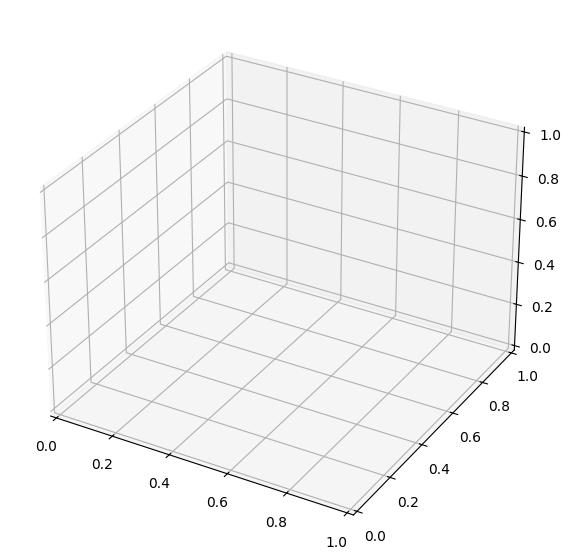

In [65]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

token_embeddings = token_embedding_layer(inputs)
print(token_embeddings.shape)

# uncomment & execute the following line to see how the embeddings look like
print(token_embeddings)

# Generate a 3D view of the embeddings for all the sequences in the torch of size 38x4x256
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
for seq_idx in range(token_embeddings.shape[0]):
    xs = token_embeddings[seq_idx, :, 0].detach().cpu().numpy()
    ys = token_embeddings[seq_idx, :, 1].detach().cpu().numpy()
    zs = token_embeddings[seq_idx, :, 2].detach().cpu().numpy()
    ax.plot(xs, ys, zs, marker='o', label=f'Seq {seq_idx+1}')
ax.set_title('3D Visualization of Token Embeddings (First 3 Dimensions)')
ax.set_xlabel('Embedding Dim 1')
ax.set_ylabel('Embedding Dim 2')
ax.set_zlabel('Embedding Dim 3')
plt.legend()
plt.show()

- GPT-2 uses absolute position embeddings, so we just create another embedding layer:

In [ ]:
context_length = max_length
pos_embedding_layer = torch.nn.Embedding(context_length, output_dim)

# uncomment & execute the following line to see how the embedding layer weights look like
# print(pos_embedding_layer.weight)

In [ ]:
pos_embeddings = pos_embedding_layer(torch.arange(max_length))
print(pos_embeddings.shape)

# uncomment & execute the following line to see how the embeddings look like
# print(pos_embeddings)

- To create the input embeddings used in an LLM, we simply add the token and the positional embeddings:

In [ ]:
input_embeddings = token_embeddings + pos_embeddings
print(input_embeddings.shape)

# uncomment & execute the following line to see how the embeddings look like
# print(input_embeddings)

- In the initial phase of the input processing workflow, the input text is segmented into separate tokens
- Following this segmentation, these tokens are transformed into token IDs based on a predefined vocabulary:

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch02_compressed/19.webp" width="700px">

# Summary and takeaways

See the [./dataloader.ipynb](./dataloader.ipynb) code notebook, which is a concise version of the data loader that we implemented in this chapter and will need for training the GPT model in upcoming chapters.

See [./exercise-solutions.ipynb](./exercise-solutions.ipynb) for the exercise solutions.

See the [Byte Pair Encoding (BPE) Tokenizer From Scratch](../02_bonus_bytepair-encoder/compare-bpe-tiktoken.ipynb) notebook if you are interested in learning how the GPT-2 tokenizer can be implemented and trained from scratch.